In [1]:
# =========================================
# Cell 1 : imports & basic settings
# =========================================
import torch
from torch import nn, optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import numpy as np
torch.manual_seed(0)

DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
print("Using", DEVICE)

Using cpu


In [2]:
# =========================================
# Cell 2 : load a slimmed-down MNIST dataset
# =========================================
transform = transforms.ToTensor()

train_ds = datasets.MNIST(root="./data", train=True, download=True, transform=transform)
test_ds  = datasets.MNIST(root="./data", train=False, download=True, transform=transform)

# Use only a subset (10 000 train, 2 000 test) for quick CPU training
train_subset, _ = torch.utils.data.random_split(train_ds,  [10_000, len(train_ds)-10_000])
test_subset , _ = torch.utils.data.random_split(test_ds,   [2_000 , len(test_ds)-2_000])

train_loader = DataLoader(train_subset, batch_size=128, shuffle=True)
test_loader  = DataLoader(test_subset , batch_size=256, shuffle=False)

100%|██████████| 9.91M/9.91M [00:00<00:00, 11.8MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 1.70MB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 4.12MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 1.20MB/s]


In [6]:
# =========================================
# Cell 3 : define Encoder, Decoder, and VAE
# =========================================
LATENT_DIM = 16   # small latent space

class Encoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(28*28, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_mu = nn.Linear(256, LATENT_DIM)
        self.fc_logvar = nn.Linear(256, LATENT_DIM)

    def forward(self, x):
        x = torch.flatten(x, 1)
        h1 = torch.relu(self.fc1(x))
        h2 = torch.relu(self.fc2(h1))
        mu     = self.fc_mu(h2)
        logvar = self.fc_logvar(h2)
        return mu, logvar

class Decoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.fc1 = nn.Linear(LATENT_DIM, 256)
        self.fc2 = nn.Linear(256, 256)
        self.fc_out = nn.Linear(256, 28*28)

    def forward(self, z):
        h1 = torch.relu(self.fc1(z))
        h2 = torch.relu(self.fc2(h1))
        xh = torch.sigmoid(self.fc_out(h2))          # pixel probs (Bernoulli)
        return xh.view(-1, 1, 28, 28)

class VAE(nn.Module):
    def __init__(self):
        super().__init__()
        self.enc = Encoder()
        self.dec = Decoder()

    def forward(self, x):
        mu, logvar = self.enc(x)
        std = torch.exp(0.5 * logvar)
        eps = torch.randn_like(std)
        z   = mu + std * eps                       # reparameterisation trick
        x_hat = self.dec(z)
        return x_hat, mu, logvar

In [4]:
# =========================================
# Cell 4 : ELBO loss function
# =========================================
def vae_loss(x, x_hat, mu, logvar):
    # Reconstruction term: binary cross-entropy
    recon = nn.functional.binary_cross_entropy(
        x_hat, x, reduction="sum"
    )
    # KL divergence term (analytic for diagonal Gaussians)
    kl = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())
    return recon + kl, recon, kl

In [10]:
# =========================================
# Cell 5 : train for a few epochs (CPU-friendly)
# =========================================
model = VAE().to(DEVICE)
opt = optim.Adam(model.parameters(), lr=1e-3)

EPOCHS = 50
history = {"loss": [], "recon": [], "kl": []}

for epoch in range(1, EPOCHS+1):
    model.train()
    epoch_loss = epoch_recon = epoch_kl = 0
    for x, _ in train_loader:
        x = x.to(DEVICE)
        x_hat, mu, logvar = model(x)
        loss, recon, kl = vae_loss(x, x_hat, mu, logvar)

        opt.zero_grad()
        loss.backward()
        opt.step()

        epoch_loss += loss.item()
        epoch_recon += recon.item()
        epoch_kl   += kl.item()

    n_samples = len(train_loader.dataset)
    if epoch % 10 == 0 or epoch == EPOCHS:
        print(f"Epoch {epoch:2d}: total {epoch_loss/n_samples:.2f}  "
              f"recon {epoch_recon/n_samples:.2f}  kl {epoch_kl/n_samples:.2f}")
    history["loss"].append(epoch_loss/n_samples)
    history["recon"].append(epoch_recon/n_samples)
    history["kl"].append(epoch_kl/n_samples)

Epoch 10: total 130.35  recon 115.71  kl 14.64
Epoch 20: total 116.74  recon 99.97  kl 16.77
Epoch 30: total 111.41  recon 93.66  kl 17.75
Epoch 40: total 107.98  recon 89.42  kl 18.56
Epoch 50: total 105.64  recon 86.74  kl 18.90


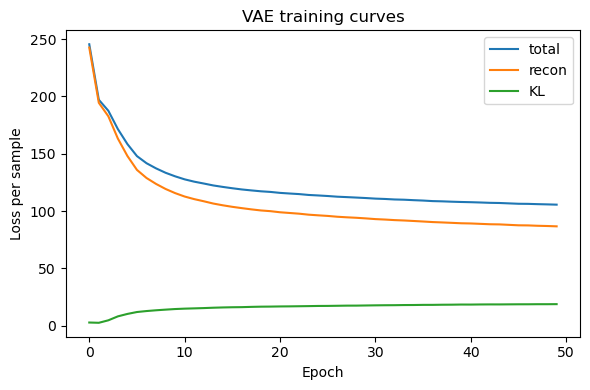

In [11]:
# =========================================
# Cell 6 : plot training loss components
# =========================================
plt.figure(figsize=(6,4))
plt.plot(history["loss"], label="total")
plt.plot(history["recon"], label="recon")
plt.plot(history["kl"], label="KL")
plt.xlabel("Epoch"); plt.ylabel("Loss per sample"); plt.title("VAE training curves")
plt.legend(); plt.tight_layout(); plt.show()

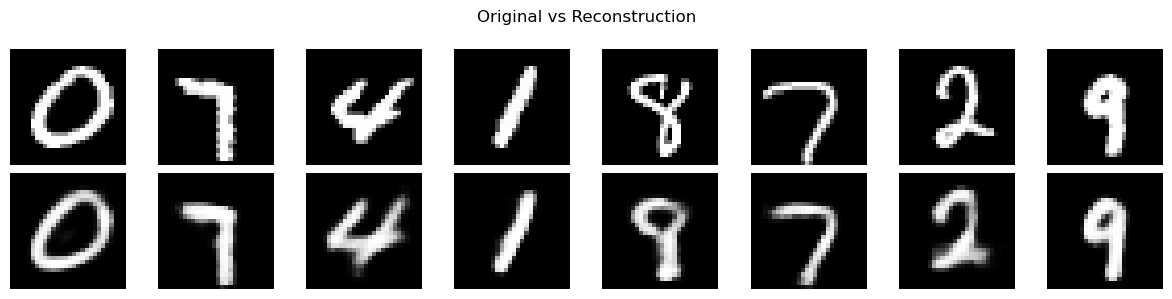

In [12]:
# =========================================
# Cell 7 : compare originals vs reconstructions
# =========================================
model.eval()
x_batch, _ = next(iter(test_loader))
x_batch = x_batch.to(DEVICE)[:8]            # take 8 images
with torch.no_grad():
    x_hat, *_ = model(x_batch)

x_batch = x_batch.cpu()
x_hat   = x_hat .cpu()

fig, axs = plt.subplots(2, 8, figsize=(12,3))
for i in range(8):
    axs[0,i].imshow(x_batch[i,0], cmap="gray"); axs[0,i].axis("off")
    axs[1,i].imshow(x_hat  [i,0], cmap="gray"); axs[1,i].axis("off")
axs[0,0].set_ylabel("Original")
axs[1,0].set_ylabel("Recon")
plt.suptitle("Original vs Reconstruction"); plt.tight_layout(); plt.show()

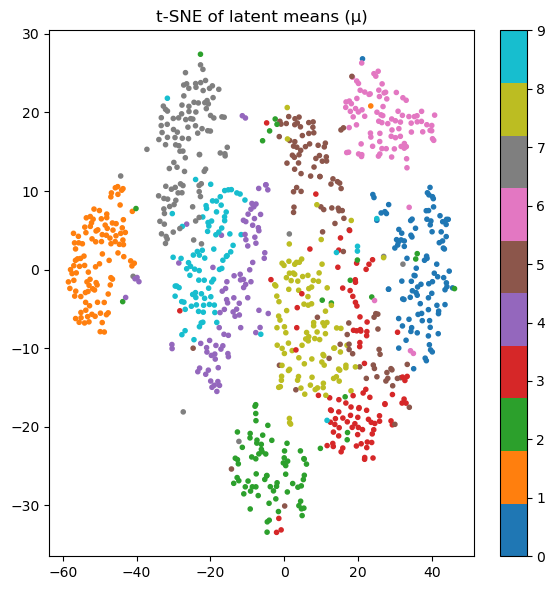

In [13]:
# =========================================
# Cell 8 : 2-D t-SNE of the latent means (just 1000 test points)
# =========================================
from sklearn.manifold import TSNE

model.eval()
latents = []
labels  = []
with torch.no_grad():
    for x, y in test_loader:
        mu, _ = model.enc(x.to(DEVICE))
        latents.append(mu.cpu())
        labels.append(y)
        if len(labels)*256 >= 1000: break  # ~1000 samples

latents = torch.cat(latents)[:1000].numpy()
labels  = torch.cat(labels) [:1000].numpy()

tsne = TSNE(n_components=2, perplexity=30, random_state=0)
lat2d = tsne.fit_transform(latents)

plt.figure(figsize=(6,6))
plt.scatter(lat2d[:,0], lat2d[:,1], c=labels, cmap="tab10", s=9)
plt.colorbar(); plt.title("t-SNE of latent means (μ)"); plt.tight_layout(); plt.show()

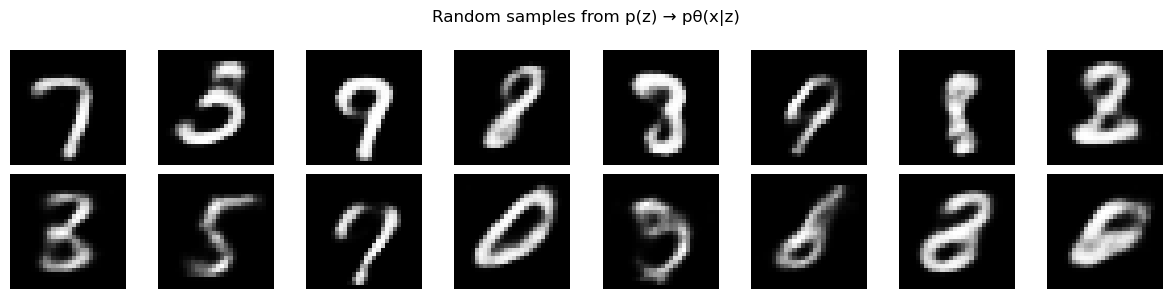

In [14]:
# =========================================
# Cell 9 : sample random z and decode
# =========================================
with torch.no_grad():
    z = torch.randn(16, LATENT_DIM).to(DEVICE)
    samples = model.dec(z).cpu()

fig, axs = plt.subplots(2, 8, figsize=(12,3))
for i in range(16):
    axs[i//8, i%8].imshow(samples[i,0], cmap="gray"); axs[i//8, i%8].axis("off")
plt.suptitle("Random samples from p(z) → pθ(x|z)"); plt.tight_layout(); plt.show()